# Importar drivers

## Os drivers estão todos localizados na pasta Instruments

In [1]:
from instruments.M8195A_driver import * # Driver do AWG
from instruments.ATS9872_driver import * # Placa Alazar

## A biblioteca de medida está localizada na pasta measurements.

In [2]:
from measurements.DataChannelManager import * # Contém classe que gerencia os dados para serem carregados no AWG
from measurements.PulseSequence import * # Classe que estratura e sequencia os pulsos

# Diferentes tipos de pulsos que podem ser usados

from measurements.waveforms.SquarePulse import *
from measurements.waveforms.ZeroPulse import *
from measurements.waveforms.GaussianPulse import *
from measurements.waveforms.DragPulse import *

## Outras bibliotecas para ajudar na medida

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import struct
from IPython.display import clear_output

## Configurar AWG

In [4]:
inst_awg = M8195A_driver('169.254.101.100')

inst_awg.setSampleRate(64e9)

# tem que conectar também o awg a nossa referência de rubídio 10 MHz
inst_awg.setRefInClockExternal()  
inst_awg.setRefInClockFrequency(10e6)

# configura o awg para usar dois canais (um de excitação, outro de medida) e usar dois markers
# o canal 1 gerará o sinal de excitação I e o sinal de medida
# o canal 2 gerará o sinal de excitação Q
# o canal 3 será o marker 1 - para ligar a fonte 2, fonte de excitação
# o canal 4 será o marker 2 - para ligar a fonte 1, de medida, e para trigar a placa de aquisição alazar
inst_awg.setDualWithMarker()

# dividir a memória em 2
inst_awg.setMemoryDivision(2)
# usar a memória externa para o canal 2
inst_awg.setChannelMemoryToExtended(2)


# markers should have 1 V amplitude and offset 0.5
inst_awg.setVoltage(3,1) 
inst_awg.setVoltage(4,1)

inst_awg.setVoltageOffset(3,0.5) 
inst_awg.setVoltageOffset(4,0.5)

inst_awg.enableChanneloutput(1)
inst_awg.enableChanneloutput(2)
inst_awg.enableChanneloutput(3)
inst_awg.enableChanneloutput(4)

In [5]:
inst_awg.getError()

## Configurar Alazar

In [6]:
inst_alazar = ATS9872_driver()

alazar_params = {}

RFMeasurementLength = 5e-6 # Escolher a duração do pulso de medida

#
# Values that work for recordsPerBuffer and BuffersPerAcquisition
#                           25                    20
#                           100                   20
#                           500                   100
alazar_params['recordsPerBuffer'] = 20  # número de capturas por buffer.
alazar_params['buffersPerAcquisition'] = 100 # número de buffers por aquisição.
alazar_params['amplitudeReferenceAlazar'] = -8 # Intensidade do sinal de referência.
alazar_params['inputLoad'] = 50# impedância dos cabos. 
alazar_params['triggerLevel_volts'] = 0.7  # Level do trigger para ativar captura.
alazar_params['triggerRange_volts'] = 1            # Tamanho máximo do sinal do trigger.
alazar_params['waveformHeadCut'] = 500 # quanto pontos iniciais por captura vão ser ignorados.
alazar_params['period'] = 14 # o período em pontos do sinal capturado ( 70 MHz -> 14 pontos).
alazar_params['buffer_timeout_ms'] = 5000 # tempo de espera para chegar um buffer; se ultrapassar, ocorre timeout.
alazar_params['decimationValue'] = 1 # valor de divisão do sampling rate.
alazar_params['TTL'] = True # Configuração do sinal de trigger. É o que funcionaou quando estava trigando pelo AWG. Quando é pelo delay generator, não usa isso.
alazar_params['save'] = False # Caso queira salvar todos os pontos adquiridos na aquisição em formato binário.


alazar_params['DefaultAlazarSamplingRate'] = 1e9
samplingRate =  alazar_params['DefaultAlazarSamplingRate']/alazar_params['decimationValue']

# O número pontos por aquisição depende do sampling rate. Tem que ser múltiplos de 256.
alazar_params['postTriggerSamples'] = int(RFMeasurementLength*samplingRate/256)*256    # quantos pontos depois do trigger.
alazar_params['preTriggerSamples'] = 0 # quantos pontos o alazar vai salvar antes do trigger.

In [7]:

# função que retornar I e Q da placa alazar
def capture(self):
    I,Q = inst_alazar.capture(preTriggerSamples = alazar_params['preTriggerSamples'],                                       
                                   postTriggerSamples = alazar_params['postTriggerSamples'],                     
                                   recordsPerBuffer = alazar_params['recordsPerBuffer'], 
                                   buffersPerAcquisition = alazar_params['buffersPerAcquisition'],       
                                   powerReference_dBm = alazar_params['amplitudeReferenceAlazar'],
                                   inputLoad = alazar_params['inputLoad'],                                              
                                   triggerLevel_volts = alazar_params['triggerLevel_volts'], 
                                   triggerRange_volts = alazar_params['triggerRange_volts'],                                      
                                   waveformHeadCut = alazar_params['waveformHeadCut'],             
                                   period = alazar_params['period'],                                                 
                                   buffer_timeout_ms = alazar_params['buffer_timeout_ms'] ,                                    
                                   decimation_value = alazar_params['decimationValue'],            
                                   TTL = alazar_params['TTL'],  
                                   save = alazar_params['save'])  

## Configurar DataChannel

In [8]:
ms = DataChannelManager(inst_awg)

ms.clearAwgChannel()

ms.labelAwgChannel(channel = 2, # o canal do awg
                        channelName = 'Q', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'I', markerValue = 1)

ms.labelAwgChannel(channel = 1, # o canal do awg
                        channelName = 'm', markerValue = 2)

# Exemplos de Medidas

### Cavidade

A ideia principal dessa medida é gerar apenas um pulso. Fazendo a varredura em frequência, se obtém a ressonância da cavidade.

In [9]:
# Define-se um pulso Zero
p1 = ZeroPulse(length = RFMeasurementLength)

In [10]:
s1 = PulseSequence('Cavidade', 1e-6)

In [14]:
s1.clear()

s1.add(p = p1, channel = 'm')

Adicionando os pulsos no PulseSequence, vai criar a seguinte estratura de dados

In [15]:
s1.channels

{'m': {'pulses': array([<measurements.waveforms.ZeroPulse.ZeroPulse object at 0x0000017EDD6EF7D0>],
        dtype=object),
  'delays': array([1.e-10]),
  'relative_delays': array([-5.0001e-06])}}

O DataChannelManager recebe uma Pulse Sequence e o converte em formato adequado para o AWG

In [16]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 100e-6)

Com isso foi a criada a seguinte estratura de dados

In [17]:
ms._channelData

{'channels': {'m': {'awgChannel': 1,
   'pulse_stream': array([0, 2, 0, ..., 2, 0, 0], dtype=int8),
   'length': 320256,
   'relative_memory_index': 160256}},
 'startupInstrumentIndex': 192256,
 'totalSizeMeasurement': 3200000,
 'awgRate': 32000000000.0}

Próximo passo é liberar a memória do awg e alocar a memória calculada em prepareChannelData

In [18]:
inst_awg.freeMemory()

In [19]:
ms.allocAwgMemory()

Para checar possíveis erros chame getError

In [20]:
inst_awg.getError()

Para carregar os dados de _channelData no canal m chame loadChannelDataToAwg

In [21]:
# Para car
ms.loadChannelDataToAwg('m')

In [22]:
# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [23]:
inst_awg.start()

### Twotone

In [24]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = GaussianPulse(length = 20e-6, amplitude = 1, sigma = 4e-6)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


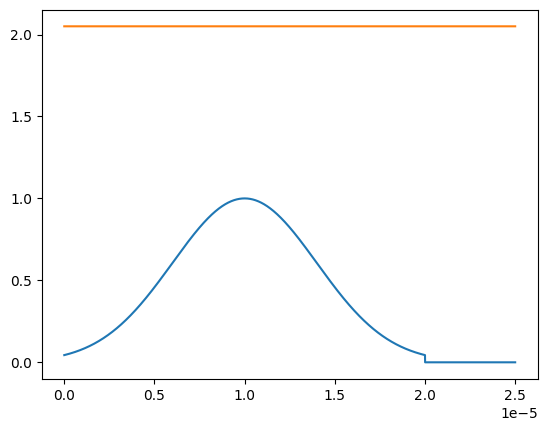

In [25]:
s1.show_all()

In [26]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 120e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [27]:
inst_awg.getError()

In [28]:
inst_awg.start()

# Rabi

In [29]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 0)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


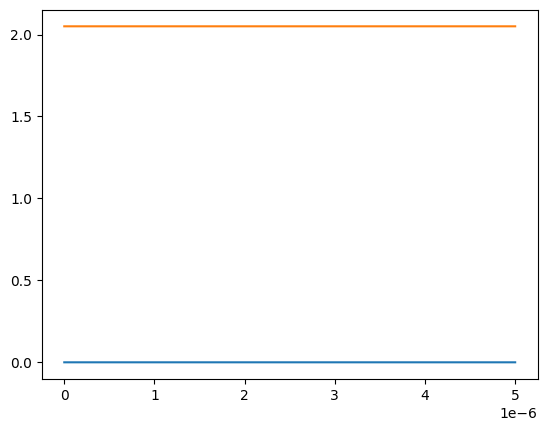

In [30]:
s1.show_all()

In [31]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 120e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [32]:
inst_awg.start()

In [37]:
durations = np.arange(0,2000e-9,10e-9)

for duration in durations:

    p1.length = duration
    
    s1.clear()

    s1.add(p = p1, channel = 'I', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'I')

    ms.loadChannelDataToAwg('I')
    sleep(0.05)
    ms.loadChannelDataToAwg('m')

    ms.setInstrumentsMarker(1)

    sleep(0.5)


### T1

In [38]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 50e-9)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


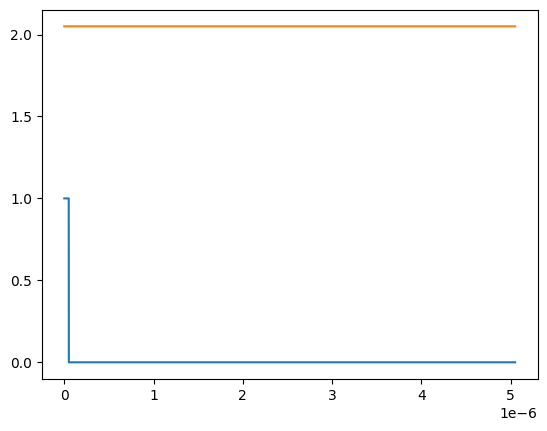

In [39]:
s1.show_all()

In [40]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [41]:
inst_awg.start()

In [42]:
delays = np.arange(0,1000e-9,10e-9)

for delay in delays:

    s1.clear()

    s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength+delay)
    s1.add(p = p2, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'Q')

    ms.loadChannelDataToAwg('Q') # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m

    ms.setInstrumentsMarker(1)

    sleep(0.5)


### Ramsey

In [43]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 25e-9)
p2 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'Q')
s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
s1.add(p = p2, channel = 'm')


In [44]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [45]:
inst_awg.start()

In [47]:
delays = np.arange(0,1000e-9,10e-9)

for delay in delays:

    s1.clear()

    s1.add(p = p1, channel = 'Q', delay = delay)
    s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
    s1.add(p = p2, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'Q')

    ms.loadChannelDataToAwg('Q')  # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m

    ms.setInstrumentsMarker(1)

    sleep(0.5)


### Echo

In [48]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 25e-9)
p2 = SquarePulse(length = 50e-9)
p3 = ZeroPulse(length = RFMeasurementLength)

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'Q')
s1.add(p = p2, channel = 'Q')
s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
s1.add(p = p3, channel = 'm')


In [49]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [50]:
inst_awg.start()

In [51]:
delays = np.arange(0,1000e-9,10e-9)

for delay in delays:

    s1.clear()

    s1.add(p = p1, channel = 'Q', delay = delay)
    s1.add(p = p2, channel = 'Q', delay = delay)
    s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)
    s1.add(p = p3, channel = 'm')

    ms.updateChannelData(sequence = s1, channelName = 'Q')

    ms.loadChannelDataToAwg('Q')  # Quando usa o canal Q, não precisa atualizar o m, a menos que haja alteração de dados no canal m

    ms.setInstrumentsMarker(1)

    sleep(0.5)


### Uma sequência de Pulsos Arbitrária

In [46]:
inst_awg.stop()

# Define-se um pulso Zero
p1 = SquarePulse(length = 25e-9)
p2 = SquarePulse(length = 50e-9)
p3 = GaussianPulse(length = 50e-9, amplitude = 1, sigma = 10e-9)
p5 = ZeroPulse(length = RFMeasurementLength)


p4 = DPC.build()

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p1, channel = 'Q', delay = 100e-9)
s1.add(p = p1, channel = 'Q', delay = RFMeasurementLength)

s1.add(p = p3, channel = 'I', delay = 50e-9)
s1.add(p = p2, channel = 'I', delay = RFMeasurementLength)

s1.add(p = p5, channel = 'm')


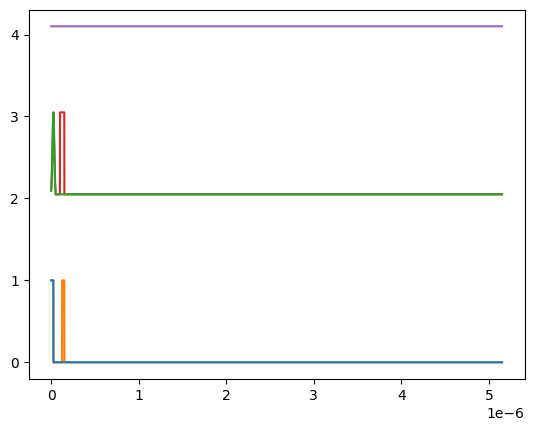

In [48]:
s1.show_all()

In [49]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)

In [50]:
inst_awg.start()

### Drag Pulse 

In [13]:
inst_awg.stop()

# Define-se um pulso Zero
p5 = ZeroPulse(length = RFMeasurementLength)

DPC = DragPulseConstructor(length = 100e-9, alpha = 1, beta = 1, sigma = 2e-9)

p4 = DPC.build()

s1 = PulseSequence('Twotone', 1e-6)

s1.clear()

s1.add(p = p4.Q, channel = 'Q', delay = RFMeasurementLength+100e-9)


s1.add(p = p4.I, channel = 'I', delay = RFMeasurementLength+100e-9)

s1.add(p = p5, channel = 'm')


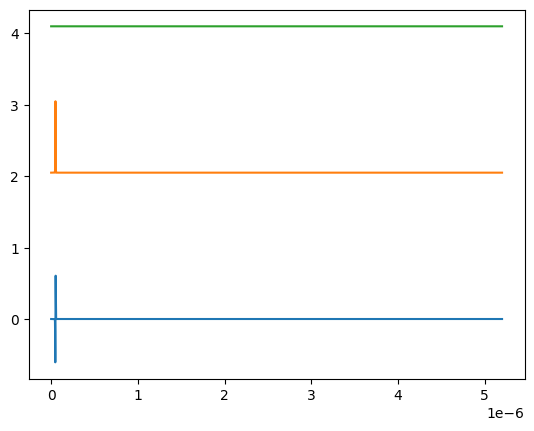

In [14]:
s1.show_all()

In [ ]:
ms.prepareChannelData(sequence = s1, totalExperimentDuration = 200e-6)

inst_awg.freeMemory()

ms.allocAwgMemory()
sleep(0.05)
ms.loadChannelDataToAwg('Q')
sleep(0.05)
ms.loadChannelDataToAwg('I')
sleep(0.05)
ms.loadChannelDataToAwg('m')
sleep(0.05)

# Atualiza o marker da fonte de excitação
ms.setInstrumentsMarker(1)